# [📖 Main Menu](index.html)

In [1]:
using StatsBase, DataFrames, DataFrameMacros
using RCall, CategoricalArrays, TexTables
using Distributions, Gadfly, Compose, MLJ
using HypothesisTests, CausalityTools

In [2]:
include("pubh.jl")
import GLM.@formula
set_default_plot_size(15cm, 12cm)
@rlibrary readr
@rimport pubh

In [3]:
#| output: false
R"""
library(tidyverse)
library(sjlabelled)
""";

┌ Warning: RCall.jl: ── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
│ ✔ dplyr     1.1.4     ✔ readr     2.1.5
│ ✔ forcats   1.0.0     ✔ stringr   1.5.1
│ ✔ ggplot2   3.4.4     ✔ tibble    3.2.1
│ ✔ lubridate 1.9.3     ✔ tidyr     1.3.1
│ ✔ purrr     1.0.2     
│ ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
│ ✖ dplyr::filter() masks stats::filter()
│ ✖ dplyr::lag()    masks stats::lag()
│ ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
└ @ RCall ~/.julia/packages/RCall/dDAVd/src/io.jl:172
┌ Warning: RCall.jl: 
│ Attaching package: ‘sjlabelled’
│ 
│ The following object is masked from ‘package:forcats’:
│ 
│     as_factor
│ 
│ The following object is masked from ‘package:dplyr’:
│ 
│     as_label
│ 
│ The following object is masked from ‘package:ggplot2’:
│ 
│     as_label
│ 
└ @ RCall ~/.julia/packages/RCall/dDAVd/src/io.jl:172


# Simple Linear Correlation

## Pearson's Correlation

In [4]:
tuzson = rcopy(R"pubh::Tuzson")
tuzson |> schema

┌───────────┬────────────┬─────────┐
│ names     │ scitypes   │ types   │
├───────────┼────────────┼─────────┤
│ flexion   │ Continuous │ Float64 │
│ extension │ Continuous │ Float64 │
└───────────┴────────────┴─────────┘


We start by constructing a scatter plot to visualise potential correlations.

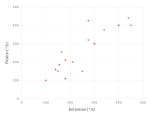

In [5]:
#| label: fig-fig1
#| fig-cap: "Relationship between flexion and extension on peak velocity in walking."
plot(
	tuzson,
	x = :extension, y = :flexion,
	Guide.xlabel("Extension (°/s)"),
	Guide.ylabel("Flexion (°/s)"),
	Theme(default_color = "IndianRed")
)

One of the assumptions is that the joint distribution is a normal distribution. We can take a look at the individual distributions as a proxy of the joint distribution.

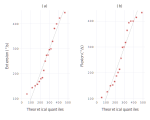

In [6]:
#| label: fig-fig2
#| fig-cap: "QQ-plots against the standard Normal distribution for variables in the Tuzson data set."
let 
  p1 =  qq_plot(tuzson.extension, ylab = "Extension (°/s)", title = "(a)")
	p2 = qq_plot(tuzson.flexion, ylab = "Flexion (°/s)", title = "(b)")
  
	hstack(p1, p2)
end

In [7]:
CorrelationTest(tuzson.extension, tuzson.flexion)

Test for nonzero correlation
----------------------------
Population details:
    parameter of interest:   Correlation
    value under h_0:         0.0
    point estimate:          0.88219
    95% confidence interval: (0.7062, 0.9555)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-05

Details:
    number of observations:          18
    number of conditional variables: 0
    t-statistic:                     7.49375
    degrees of freedom:              16


## Spearman's Correlation

For variables whose joint distribution is not normal, or where the association is monotonic but not linear, the Spearman's ρ-coefficient can be used. This is the most common non-parametric alternative for linear correlations.

A classic example of when to use Spearman's instead of Pearson's correlation coefficient is when we have ordinal instead of continuous variables.

In [8]:
R"""
data(bfi, package = "psych")
labs <- c("Very Inaccurate", "Moderately Inaccurate", "Slightly Inaccurate",
            "Slightly Accurate", "Moderately Accurate", "Very Accurate")
bfi = bfi %>%
  mutate(
    a3 = factor(A3, labels = labs),
    a5 = factor(A5, labels = labs),
    sex = factor(gender, labels = c("Male", "Female")),
    id = 1:nrow(bfi)
  ) %>%
  var_labels(
    A3 = "Know how to comfort others",
    A5 = "Make people feel at ease",
    sex = "Sex"
  ) %>%
  select(A3, A5, a3, a5, sex)
""";

In [9]:
bfi = @rget bfi
dropmissing!(bfi)
bfi |> schema

┌───────┬───────────────┬──────────────────────────────────┐
│ names │ scitypes      │ types                            │
├───────┼───────────────┼──────────────────────────────────┤
│ A3    │ Count         │ Int64                            │
│ A5    │ Count         │ Int64                            │
│ a3    │ Multiclass{6} │ CategoricalValue{String, UInt32} │
│ a5    │ Multiclass{6} │ CategoricalValue{String, UInt32} │
│ sex   │ Multiclass{2} │ CategoricalValue{String, UInt32} │
└───────┴───────────────┴──────────────────────────────────┘


The distribution of **Know how to comfort others** by sex.

In [10]:
tabulate(bfi, :a3, :sex)

   |                       |      sex      |       
   |                       | Female | Male | Total 
---------------------------------------------------
a3 |       Very Inaccurate |     57 |   33 |    90 
   | Moderately Inaccurate |     93 |   78 |   171 
   |   Slightly Inaccurate |    115 |   91 |   206 
   |     Slightly Accurate |    341 |  221 |   562 
   |   Moderately Accurate |    669 |  311 |   980 
   |         Very Accurate |    575 |  174 |   749 
---------------------------------------------------
   |                 Total |   1850 |  908 |  2758 


The distribution of **Make people feel at ease** by sex.

In [11]:
tabulate(bfi, :a5, :sex)

   |                       |      sex      |       
   |                       | Female | Male | Total 
---------------------------------------------------
a5 |       Very Inaccurate |     32 |   27 |    59 
   | Moderately Inaccurate |    107 |   79 |   186 
   |   Slightly Inaccurate |    150 |  102 |   252 
   |     Slightly Accurate |    408 |  203 |   611 
   |   Moderately Accurate |    651 |  311 |   962 
   |         Very Accurate |    502 |  186 |   688 
---------------------------------------------------
   |                 Total |   1850 |  908 |  2758 


To compare the distributions in a single plot, we combine the frequency tables in a new data frame.

In [12]:
bfi_melt = stack(bfi, [:a3, :a5], :sex)
bfi_melt |> head

Row,sex,variable,value
,Cat…,String,Cat…
1,Male,a3,Slightly Inaccurate
2,Female,a3,Moderately Accurate
3,Female,a3,Moderately Accurate
4,Female,a3,Very Accurate
5,Male,a3,Slightly Inaccurate


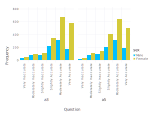

In [13]:
#| label: fig-fig3
#| fig-cap: "Distribution comparison of questions A3: Know how to comfort others and A5: Make people at ease."
plot(
	@combine(groupby(bfi_melt, [:sex, :value, :variable]), :count = @nrow),
	x=:value, y=:count, color=:sex, xgroup=:variable,
	Geom.subplot_grid(Geom.bar(position=:dodge)),
	Guide.xlabel("Question"),
	Guide.ylabel("Frequency")
)

In [14]:
corspearman(bfi.A3, bfi.A5) |> r3

0.53

## Kendall's Correlation

Kendall's $\tau$ is a non-parametric correlation that should be used instead of Spearman's when the sample size is relatively small, and the data has a relatively large number of ties.

In [15]:
attitude = rcopy(R"datasets::attitude")
attitude |> schema

┌────────────┬────────────┬─────────┐
│ names      │ scitypes   │ types   │
├────────────┼────────────┼─────────┤
│ rating     │ Continuous │ Float64 │
│ complaints │ Continuous │ Float64 │
│ privileges │ Continuous │ Float64 │
│ learning   │ Continuous │ Float64 │
│ raises     │ Continuous │ Float64 │
│ critical   │ Continuous │ Float64 │
│ advance    │ Continuous │ Float64 │
└────────────┴────────────┴─────────┘


For this example, we are going to look at the correlation matrix, i.e., the correlations between all the variables.

In [16]:
att_mat = Matrix(attitude);

We can use a heatmap to construct a correlation plot.

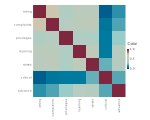

In [17]:
#| label: fig-fig4
#| fig-cap: "Heatmap showing the relationships between all variables in the attitude data set."
let
	att_cor = corkendall(att_mat)
	labs = names(attitude)

	spy(
		att_cor,
		Guide.xlabel(""),
		Guide.ylabel(""),
		Scale.x_discrete(labels = i->labs[i]),
		Guide.xticks(orientation=:vertical),
		Scale.y_discrete(labels = i->labs[i])
	)
end

In [18]:
corkendall(att_mat)

7×7 Matrix{Float64}:
 1.0        0.654971   0.355556   0.449123   0.443663  0.0306611  0.132079
 0.654971   1.0        0.385514   0.450935   0.487694  0.0777412  0.171973
 0.355556   0.385514   1.0        0.35514    0.335289  0.0871643  0.273272
 0.449123   0.450935   0.35514    1.0        0.51114   0.0848085  0.391062
 0.443663   0.487694   0.335289   0.51114    1.0       0.200948   0.394803
 0.0306611  0.0777412  0.0871643  0.0848085  0.200948  1.0        0.180523
 0.132079   0.171973   0.273272   0.391062   0.394803  0.180523   1.0

# Mutual Information

## Continuous variables

We can also use functions from the CausalityTools package. The `SurrogateTest` is a generic one-sided hypothesis test that checks whether $x$ and $y$ are independent (given $z$, if provided) based on resampling from a null distribution assumed to represent independence between the variables. The null distribution is generated by repeatedly shuffling the input data in some way that is intended to break any dependence between the input variables.

Let's take a look first at how to test independence with Pearson's Correlation using SurrogateTest:

In [20]:
independence(
	SurrogateTest(PearsonCorrelation()),
	tuzson.extension, tuzson.flexion
)

`SurrogateTest` independence test
---------------------------------------------------------------------
H₀: "The first two variables are independent, given the 3rd variable"
Hₐ: "The first two variables are dependent, given the 3rd variable"
---------------------------------------------------------------------
Estimated: 0.8821900098276608
Ensemble quantiles (100 permutations):
    (99.9%): 0.4542479730720872
    (99%):   0.42894059995114303
    (95%):   0.333649129765105
p-value:   0.0
α = 0.05:  ✓ Evidence favors dependence
α = 0.01:  ✓ Evidence favors dependence
α = 0.001: ✓ Evidence favors dependence


That give us the same result that we got before. Now let's calculate Shannon's mutual information (entropy). The higher is the mutual information, that indicates that variables are not independent.

In [21]:
CausalityTools.mutualinfo(
  GaussianMI(),
  tuzson.extension, tuzson.flexion
) |> r3

1.087

In [22]:
independence(
	SurrogateTest(MIShannon(), Dispersion()),
	tuzson.extension, tuzson.flexion
)

`SurrogateTest` independence test
---------------------------------------------------------------------
H₀: "The first two variables are independent, given the 3rd variable"
Hₐ: "The first two variables are dependent, given the 3rd variable"
---------------------------------------------------------------------
Estimated: 0.9080892502091431
Ensemble quantiles (100 permutations):
    (99.9%): 0.6865339436789302
    (99%):   0.5682111471635516
    (95%):   0.4149181959890542
p-value:   0.0
α = 0.05:  ✓ Evidence favors dependence
α = 0.01:  ✓ Evidence favors dependence
α = 0.001: ✓ Evidence favors dependence


## Categorical variables

When our variables are categorical, instead of using the Pearson's correlation for the surrogate test, we can test for Shannon's Mutual Information (entropy) and add the `Contingency` function instead of `Dispersion`.

Let's go back to the comparison of question A3: Know how to comfort others with question A5: Make people at ease

In [23]:
independence(
	SurrogateTest(MIShannon(), Contingency()),
	bfi.a3, bfi.a5
)

`SurrogateTest` independence test
---------------------------------------------------------------------
H₀: "The first two variables are independent"
Hₐ: "The first two variables are dependent"
---------------------------------------------------------------------
Estimated: 0.2769622430518427
Ensemble quantiles (100 permutations):
    (99.9%): 0.011537353022797915
    (99%):   0.011259464378887704
    (95%):   0.010359555111605539
p-value:   0.0
α = 0.05:  ✓ Evidence favors dependence
α = 0.01:  ✓ Evidence favors dependence
α = 0.001: ✓ Evidence favors dependence


For the `attitude` example, the greatest Kendall correlation was between `rating` and `complaints`. Are those two variables independent?

In [24]:
independence(
	SurrogateTest(MIShannon(), Contingency()),
	attitude.rating, attitude.complaints
)

`SurrogateTest` independence test
---------------------------------------------------------------------
H₀: "The first two variables are independent"
Hₐ: "The first two variables are dependent"
---------------------------------------------------------------------
Estimated: 3.9068905956085196
Ensemble quantiles (100 permutations):
    (99.9%): 4.040223928941853
    (99%):   4.0402239289418524
    (95%):   3.9735572622751865
p-value:   0.57
α = 0.05:  ✖ Independence cannot be rejected
α = 0.01:  ✖ Independence cannot be rejected
α = 0.001: ✖ Independence cannot be rejected


# Autocorrelation

When variables are recorded over time ( $t$ > 30 observations), they become a time series. In a time series, seasonality can be detected by the autocorrelation function.

In [25]:
cvd = rcopy(R"season::CVD")
cvd |> schema

┌────────────┬────────────┬─────────┐
│ names      │ scitypes   │ types   │
├────────────┼────────────┼─────────┤
│ year       │ Continuous │ Float64 │
│ month      │ Continuous │ Float64 │
│ yrmon      │ Continuous │ Float64 │
│ cvd        │ Continuous │ Float64 │
│ tmpd       │ Continuous │ Float64 │
│ pop        │ Continuous │ Float64 │
│ ndaysmonth │ Continuous │ Float64 │
│ adj        │ Continuous │ Float64 │
└────────────┴────────────┴─────────┘


First, we can look at the time series.

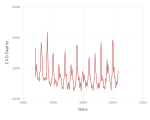

In [26]:
#| label: fig-fig6
#| fig-cap: "Monthly number of cardiovascular disease (CVD) deaths in Los Angeles."
plot(
	cvd,
	x=:yrmon, y=:cvd,
	Geom.path, 
	Guide.xlabel("Date"),
	Guide.ylabel("CVD Deaths"),
	Theme(default_color="IndianRed", line_width=0.5mm)
)

Is better to use the autocorrelation function (ACF) on a detrended series. Our time series does not show any trend, but we still are going to remove the mean (centring). In `autocor`, the default is: `dmean=true`.

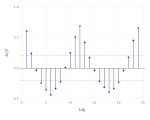

In [27]:
#| label: fig-fig7
#| fig-cap: "Autocorrelation function (ACF) for the monthly number of cardiovascular disease (CVD) deaths in Los Angeles. Each lag represents one month."
plot(
	x=[1:1:24;], y=autocor(cvd.cvd, [1:1:24;]),
	yintercept=[0.2, 0, -0.2],
	Geom.hair, Geom.point, 
	Geom.hline(
		style=[:dash, :solid, :dash],
		color=["cadetblue", "black", "cadetblue"],
		size=[0.2mm, 0.2mm, 0.2mm]
	),
	Guide.xlabel("Lag"),
	Guide.ylabel("ACF"),
	Theme(default_color="MidnightBlue"),
)